In [1]:
# load packages
import os
import shutil
from tqdm import tqdm
import csv
import requests
import sqlite3
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(
    "ignore", category=UserWarning, module="matplotlib.font_manager"
)

## Get in-situ data from OpenAQ API

In [2]:
# list of cities
csv_file_path = "data/CAMS_locations_v1.csv"

# local database file
db_file = "data/01_openaq_station-data.db"

pollutants = ["o3", "no2", "so2", "pm10", "pm25"]
pollutant_labels = ["$O_3$", "$NO_2$", "$SO_2$", "$PM_{10}$", "$PM_{2.5}$"]

# API query parameters
end_date = datetime.now()
start_date = end_date - timedelta(days=7)

# plot directories
map_directory = "figures/01/maps"
ts_directory = "figures/01/city_time_series"
# remove old plots
if os.path.exists(map_directory):
    shutil.rmtree(map_directory)
if os.path.exists(ts_directory):
    shutil.rmtree(ts_directory)
os.makedirs(map_directory)
os.makedirs(ts_directory)

### fetch data and store in local database
query data for the last week for each city via the openaq API and store all results
in local SQL database for further analysis

In [3]:
if os.path.exists(db_file):
    os.remove(db_file)

# create a connection to the SQLite database
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

# create tables for each pollutant
for parameter in pollutants:
    cursor.execute(
        f"""
    CREATE TABLE IF NOT EXISTS {parameter} (
        location_id TEXT,
        location_name TEXT,
        city TEXT,
        country TEXT,
        latitude REAL,
        longitude REAL,
        date_utc TEXT,
        value REAL
    )
    """
    )
conn.commit()


def call_openaq_api(latitude, longitude):
    url = "https://api.openaq.org/v2/measurements"
    all_results = []
    page = 1
    while True:
        # print(f'Fetching data from page {page}...')
        params = {
            "coordinates": f"{latitude},{longitude}",
            "date_from": start_date.strftime("%Y-%m-%dT%H:%M:%SZ"),
            "date_to": end_date.strftime("%Y-%m-%dT%H:%M:%SZ"),
            "limit": 100000,
            "radius": "25000",  # 25 km radius
            "order_by": "datetime",
            "page": page,
            "offset": "0",
        }
        # filter for multiple pollutants by appending them to the URL
        for parameter in pollutants:
            params[f"parameter[]"] = parameter
        # personal API key
        headers = {
            "X-API-Key": "e468891dfc9883eda10e5d94b6cef19c8dbf30fab53ddc3a910ce59fc0ce9e6f"
        }
        response = requests.get(url, params=params, headers=headers)
        data = response.json()
        results = data.get("results", [])
        # print(len(results))

        all_results.extend(results)

        # Check if there are more pages to fetch
        if len(results) < params["limit"]:
            break

        page += 1
    return all_results


# get city list from CSV file
with open(csv_file_path, mode="r", newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    city_rows = list(reader)

for row in tqdm(city_rows[:], desc="Fetching data for cities"):
    city_id = row["id"]
    city_name = row["city"]
    country = row["country"]
    latitude = row["latitude"]
    longitude = row["longitude"]

    # print(f'fetching data for {city_name}, {country}, {latitude}, {longitude}...')

    # call the OpenAQ API for the current city's location
    results = call_openaq_api(latitude, longitude)

    # process and insert the results into the database
    for result in results:
        parameter = result["parameter"]
        if parameter in pollutants:
            location_id = result["locationId"]
            location_name = result["location"]
            date_utc = result["date"]["utc"]
            value = result["value"]
            coordinates = result["coordinates"]

            # insert data into the respective table
            cursor.execute(
                f"""
            INSERT INTO {parameter} (location_id, location_name, city, country, latitude, longitude, date_utc, value)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
            """,
                (
                    location_id,
                    location_name,
                    city_name,
                    country,
                    coordinates["latitude"],
                    coordinates["longitude"],
                    date_utc,
                    value,
                ),
            )
    conn.commit()

conn.close()

Fetching data for cities: 100%|███████████████████████████████████████████████████████████████████████| 153/153 [03:03<00:00,  1.20s/it]


### load data from local database

In [4]:
# read the data into a pandas DataFrame for further analysis
def get_data(parameter):
    conn = sqlite3.connect(db_file)
    df = pd.read_sql_query(f"SELECT * FROM {parameter}", conn)
    conn.close()
    return df


# load data for each parameter
data = {parameter: get_data(parameter) for parameter in pollutants}

### overview maps of available data
let's start with some maps for each pollutant to show for which cities we actually have data available

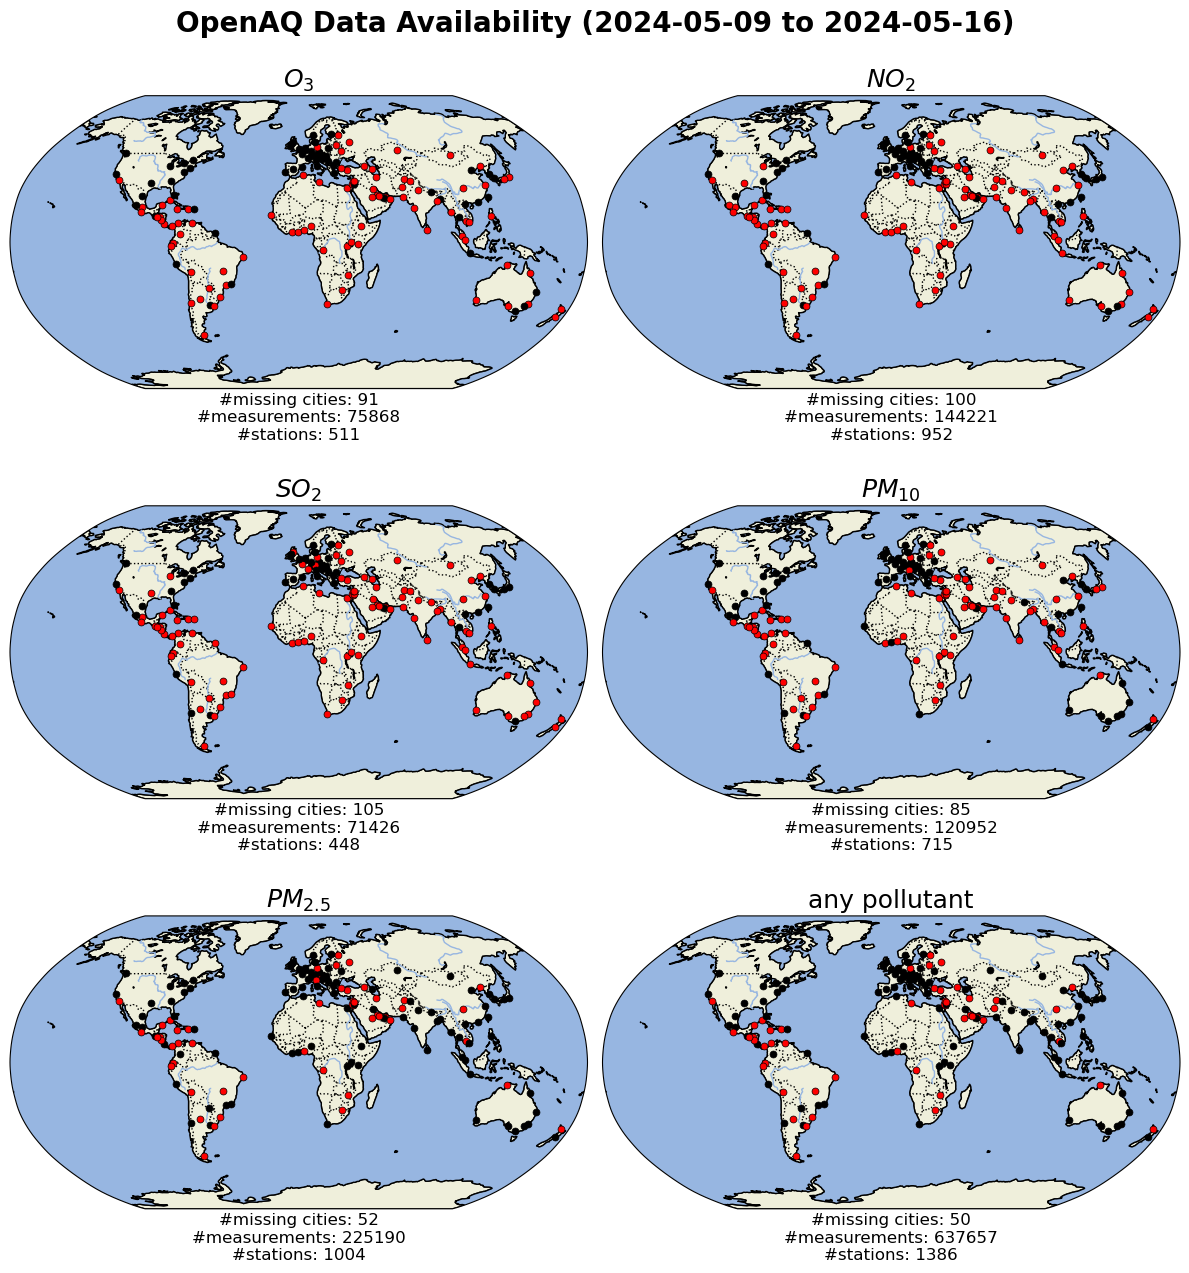

In [5]:
def check_data_availability(city, pollutant_data):
    return not pollutant_data[pollutant_data["city"] == city].empty


def check_any_data_availability(city):
    for parameter in pollutants:
        if check_data_availability(city, data[parameter]):
            return True
    return False


date_range_str = f'{start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}'

# create global maps with cartopy
fig, axes = plt.subplots(
    nrows=3, ncols=2, figsize=(12, 13), subplot_kw={"projection": ccrs.Robinson()}
)
axes = axes.flatten()

available_color = "black"
not_available_color = "red"
edge_color = "black"

# one map for each pollutant
for i, parameter in enumerate(pollutants):
    ax = axes[i]
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor="black")
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAKES, edgecolor="black")
    ax.add_feature(cfeature.RIVERS)

    missing_locations = 0
    available_measurements = 0
    unique_stations = set()

    for row in city_rows:
        city_name = row["city"]
        latitude = float(row["latitude"])
        longitude = float(row["longitude"])
        if check_data_availability(city_name, data[parameter]):
            ax.plot(
                longitude,
                latitude,
                marker="o",
                color=available_color,
                markersize=5,
                markeredgecolor=edge_color,
                markeredgewidth=0.5,
                transform=ccrs.PlateCarree(),
            )
            available_measurements += len(
                data[parameter][data[parameter]["city"] == city_name]
            )
            unique_stations.update(
                data[parameter][data[parameter]["city"] == city_name]["location_name"]
            )
        else:
            ax.plot(
                longitude,
                latitude,
                marker="o",
                color=not_available_color,
                markersize=5,
                markeredgecolor=edge_color,
                markeredgewidth=0.5,
                transform=ccrs.PlateCarree(),
            )
            missing_locations += 1

    ax.set_title(f"{pollutant_labels[i]}", fontsize=18)
    ax.text(
        0.5,
        -0.1,
        f"#missing cities: {missing_locations}\n#measurements: {available_measurements}\n#stations: {len(unique_stations)}",
        transform=ax.transAxes,
        ha="center",
        va="center",
        fontsize=12,
    )

# additional subplot for availability of any pollutant
ax = axes[-1]
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, edgecolor="black")
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES, edgecolor="black")
ax.add_feature(cfeature.RIVERS)

missing_locations = 0
available_measurements = 0
unique_stations = set()
for row in city_rows:
    city_name = row["city"]
    latitude = float(row["latitude"])
    longitude = float(row["longitude"])
    if check_any_data_availability(city_name):
        ax.plot(
            longitude,
            latitude,
            marker="o",
            color=available_color,
            markersize=5,
            markeredgecolor=edge_color,
            markeredgewidth=0.5,
            transform=ccrs.PlateCarree(),
        )
        for parameter in pollutants:
            available_measurements += len(
                data[parameter][data[parameter]["city"] == city_name]
            )
            unique_stations.update(
                data[parameter][data[parameter]["city"] == city_name]["location_name"]
            )
    else:
        ax.plot(
            longitude,
            latitude,
            marker="o",
            color=not_available_color,
            markersize=5,
            markeredgecolor=edge_color,
            markeredgewidth=0.5,
            transform=ccrs.PlateCarree(),
        )
        missing_locations += 1

ax.set_title("any pollutant", fontsize=18)
ax.text(
    0.5,
    -0.1,
    f"#missing cities: {missing_locations}\n#measurements: {available_measurements}\n#stations: {len(unique_stations)}",
    transform=ax.transAxes,
    ha="center",
    va="center",
    fontsize=12,
)

fig.suptitle(
    f"OpenAQ Data Availability ({date_range_str})",
    fontsize=20,
    y=0.98,
    fontweight="bold",
)

plt.tight_layout()
plt.savefig(
    f'{map_directory}/openaq_availability_global_maps_{end_date.strftime("%Y-%m-%d")}.png',
    dpi=200,
)
plt.show()

### plot all available time series for all cities
Let's look at the time series data of the last 7 days for all returned locations within a 25 km search radius around the city center location. This will give us an idea about how many stations are available for each city, how homogenous the stations are within a single city and to check for data gaps and outliers. Cities with no data for any pollutant (see maps above) will be skipped.

In [ ]:
# Read the CSV file to get the city names
with open(csv_file_path, mode="r", newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    city_rows = list(reader)

for row in city_rows[:]:
    city_name = row["city"]
    country_name = row["country"]
    print(city_name)

    # Check if there is any data available for this city
    city_has_data = any(
        not data[parameter][data[parameter]["city"] == city_name].empty
        for parameter in pollutants
    )

    if not city_has_data:
        print(f"No data available for {city_name}. Skipping plot.")
        continue

    fig, axes = plt.subplots(
        nrows=len(pollutants), ncols=1, figsize=(15, 26), sharex=False
    )
    fig.suptitle(
        f"Time Series of Air Pollutants for {city_name} ({country_name})",
        fontsize=20,
        fontweight="bold",
        y=0.98,
    )

    for i, parameter in enumerate(pollutants):
        ax = axes[i]
        city_data = data[parameter][data[parameter]["city"] == city_name]

        # Ensure date_utc column is of datetime type
        city_data.loc[:, "date_utc"] = pd.to_datetime(city_data["date_utc"])

        # Sort city_data by date_utc in ascending order
        city_data = city_data.sort_values(by="date_utc")

        # Plotting each location individually
        for location in city_data["location_name"].unique():
            location_data = city_data[city_data["location_name"] == location]

            # Remove duplicate dates
            location_data = location_data.drop_duplicates(subset=["date_utc"])

            # Resample data to fill missing dates with NaN
            location_data = (
                location_data.set_index("date_utc")
                .resample("h")
                .asfreq()
                .reset_index()
                .infer_objects()
            )

            ax.plot(
                location_data["date_utc"],
                location_data["value"],
                marker="o",
                label=location[:15],
            )
        ax.axvline(x=end_date, color="k", linestyle="--", linewidth=1)
        ax.text(
            end_date,
            ax.get_ylim()[1],
            "query time",
            color="k",
            fontsize=12,
            rotation=90,
            verticalalignment="top",
        )

        ax.set_title(f"{pollutant_labels[i]}", fontsize=18)
        ax.set_ylabel("Value (µg/m³)")
        handles, labels = ax.get_legend_handles_labels()
        if labels:
            ax.legend(
                title="Station",
                bbox_to_anchor=(1.05, 1),
                loc="upper left",
                prop={"size": 8},
            )

        # Define the min and max for the x-axis
        plot_end_date = datetime.now().replace(
            hour=0, minute=0, second=0, microsecond=0
        ) + timedelta(days=1)
        start_date = plot_end_date - timedelta(days=7)

        # Manually set the min and max for the x-axis, ensuring it is linear
        ax.set_xlim(start_date, plot_end_date)
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

        # Rotate x-axis labels
        for label in ax.get_xticklabels():
            label.set_rotation(45)

    plt.xlabel("Date (UTC)")
    plt.subplots_adjust(left=0.05, right=0.8)
    plt.tight_layout(rect=[0, 0, 1.0, 0.97])

    filename = f"{ts_directory}/{city_name.replace(' ', '_')}_OpenAQ_individual_pollutants_{start_date.strftime('%Y%m%d')}_{end_date.strftime('%Y%m%d')}.pdf"
    plt.savefig(filename)
    # show plot inline
    # plt.show()
    plt.close(fig)